## Import Libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Download Data

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

## Plot Examples

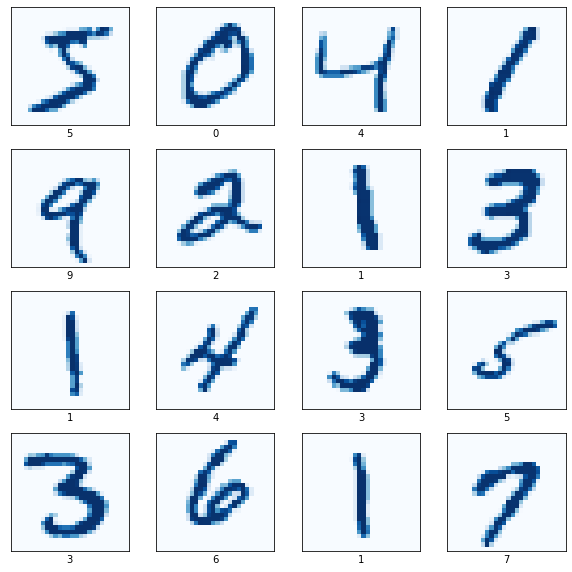

In [4]:
plt.figure(figsize=(10,10))

for i in range (0, 16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i], cmap='Blues')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

Here is a list of colors to show how we can customize our visualization.

In [5]:
colors = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn','viridis', 'plasma', 
            'inferno', 'magma', 'cividis', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
            'twilight', 'twilight_shifted', 'hsv', 'Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c',
'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']
print(len(colors))

80


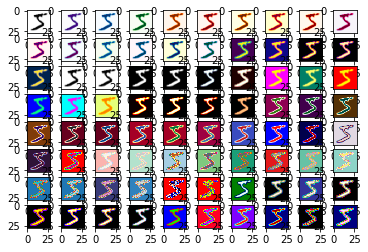

In [6]:
for i in range (len(colors)):
    plt.subplot(8, 10, i+1)
    plt.imshow(X_train[0], cmap=colors[i])

## Normalize Data

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
# Reshape X_train; makes it unstacking
X_train = np.reshape(X_train, (60000, 28*28))
X_train.shape

(60000, 784)

In [9]:
X_test.shape

(10000, 28, 28)

In [10]:
# Reshape X_test; makes it unstacking
X_test = np.reshape(X_test, (10000, 28*28))
X_test.shape

(10000, 784)

In [11]:
X_train = X_train / 255.
X_test = X_test / 255.

### Create a Neural Network Model

In [12]:
# We use two hidden layer and one output layer
# We use 32 units
# We use activation function sigmoid 
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(32, activation='sigmoid', input_shape = (784, )),
     tf.keras.layers.Dense(32, activation='sigmoid'),
     tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss= 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Train the Model

In [14]:
_ = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=1024,
    verbose=2
)

Epoch 1/20
59/59 - 0s - loss: 0.3346 - accuracy: 0.9193 - val_loss: 0.3181 - val_accuracy: 0.9211
Epoch 2/20
59/59 - 0s - loss: 0.3109 - accuracy: 0.9236 - val_loss: 0.2988 - val_accuracy: 0.9238
Epoch 3/20
59/59 - 0s - loss: 0.2917 - accuracy: 0.9266 - val_loss: 0.2824 - val_accuracy: 0.9261
Epoch 4/20
59/59 - 0s - loss: 0.2752 - accuracy: 0.9300 - val_loss: 0.2699 - val_accuracy: 0.9294
Epoch 5/20
59/59 - 0s - loss: 0.2617 - accuracy: 0.9320 - val_loss: 0.2580 - val_accuracy: 0.9318
Epoch 6/20
59/59 - 0s - loss: 0.2493 - accuracy: 0.9352 - val_loss: 0.2487 - val_accuracy: 0.9354
Epoch 7/20
59/59 - 0s - loss: 0.2387 - accuracy: 0.9374 - val_loss: 0.2392 - val_accuracy: 0.9356
Epoch 8/20
59/59 - 0s - loss: 0.2294 - accuracy: 0.9393 - val_loss: 0.2312 - val_accuracy: 0.9375
Epoch 9/20
59/59 - 0s - loss: 0.2206 - accuracy: 0.9415 - val_loss: 0.2247 - val_accuracy: 0.9387
Epoch 10/20
59/59 - 0s - loss: 0.2128 - accuracy: 0.9435 - val_loss: 0.2184 - val_accuracy: 0.9402
Epoch 11/20
59/59 -

### Save the Model

In [16]:
model.save('model.h5')

### Model Server

In [1]:
%%writefile ml_server.py
import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)
_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test/255

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index, :, :]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image
    
@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps(
            {
                'prediction': final_preds,
                'image': image.tolist()
            }
        )
    return 'Welcome to the model server!'

if __name__ == '__main__':
    app.run()


Overwriting ml_server.py


### Streamlit Web App

In [1]:
%%writefile app.py
import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI = 'http://127.0.0.1:5000'
st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')

if st.button('Get random prediction'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))
    
    st.sidebar.image(image, width=150)
    
    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        plt.figure(figsize=(32, 4))
        if layer == 2:
            row = 1
            col = 10
        else:
            row = 2
            col = 16
        
        for i, number in enumerate(numbers):
            plt.subplot(row, col, i+1)
            plt.imshow(number * np.ones([8, 8, 3]).astype('float64'))
            plt.xticks([])
            plt.yticks([])
            
            if layer == 2:
                plt.xlabel(str(i), fontsize = 40)
        
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()
        st.text('Layer{}'.format(layer+1))
        st.pyplot()
        
                
            
    


Overwriting app.py
